<a href="https://colab.research.google.com/github/MarioViniciusBC/neural-network-from-scratch/blob/main/rede_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementação de Rede Neural (MLP) do Zero: O Problema do XOR

## Objetivo
Este notebook tem como objetivo demonstrar a construção passo a passo de uma rede neural *Multi-Layer Perceptron* (MLP) utilizando puramente Python e a biblioteca NumPy. O foco é desmistificar a "caixa preta" dos algoritmos de aprendizado de máquina, traduzindo a teoria matemática (cálculo e álgebra linear) diretamente para o código.

## O Problema: Porta Lógica XOR
A rede será treinada para resolver o problema clássico da porta lógica XOR (Ou Exclusivo). Este é um marco histórico no estudo de redes neurais, pois ilustra um problema não-linearmente separável, provando a necessidade matemática da existência de camadas ocultas (*hidden layers*) para que o modelo consiga encontrar a solução.

## Arquitetura da Rede
* **Camada de Entrada:** 2 neurônios (representando os sinais $x_1$ e $x_2$).
* **Camada Oculta:** 1 camada contendo 3 neurônios ($m_1, m_2$ e $m_3$).
* **Camada de Saída:** 1 neurônio (representando a previsão final).
* **Viés (Bias):** Omitido nesta implementação para isolar e facilitar a compreensão da atualização estrita das matrizes de peso.
* **Função de Ativação:** Função Sigmoide ($y = \frac{1}{1 + e^{-x}}$) aplicada tanto na camada oculta quanto na saída.

## Pesos Iniciais (Definidos Aleatoriamente)
Para fins de validação dos cálculos manuais, a rede é inicializada com os seguintes pesos fixos:

**Pesos da Camada Oculta (Conexões das Entradas $x_1, x_2$ para $m_1, m_2, m_3$):**
* Neurônio $m_1$: `-0.424` (de $x_1$) e `0.358` (de $x_2$)
* Neurônio $m_2$: `-0.740` (de $x_1$) e `-0.577` (de $x_2$)
* Neurônio $m_3$: `-0.961` (de $x_1$) e `-0.469` (de $x_2$)

**Pesos da Camada de Saída (Conexões de $m_1, m_2, m_3$ para a Saída):**
* Conexão de $m_1$: `-0.017`
* Conexão de $m_2$: `-0.893`
* Conexão de $m_3$: `0.148`

## Metodologia de Aprendizado
1. **Feedforward:** Propagação do sinal iterando sobre os registros e calculando o produto escalar das entradas pelos pesos.
2. **Função de Custo:** Avaliação do modelo utilizando a média do erro absoluto entre a previsão e a classe real.
3. **Backpropagation:** Aplicação da regra da cadeia para calcular os gradientes intermediários (Deltas), mapeando a "parcela de culpa" de cada neurônio no erro final.
4. **Otimização:** Atualização dos pesos utilizando o algoritmo do **Gradiente Descendente em Lote** (*Batch Gradient Descent*), acumulando os deltas de toda a época. A fórmula de atualização incorpora o parâmetro de inércia (**Momento = 1**) para acelerar a convergência e evitar mínimos locais, operando com uma taxa de aprendizagem ($\alpha$) de **0.3**.

In [11]:
import numpy as np

In [10]:
# Função de ativação Sigmoide
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [9]:
# Derivada da função sigmoide
def derivada_sigmoid(y):
  return y * (1 - y)

In [6]:
# 1. Definindo todos os registros (Tabela XOR)
entradas = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

# Classes esperadas para cada registro respectivo
classes_esperadas = np.array([0, 1, 1, 0])

In [13]:
# 2. Pesos iniciais
pesos_oculta = np.array([
    [-0.424,  0.358],
    [-0.740, -0.577],
    [-0.961, -0.469]
])

pesos_saida = np.array([-0.017, -0.893, 0.148])

### Etapa 1: Propagação do Sinal (Feedforward) e Função de Custo

Nesta primeira fase, implementamos o fluxo de informação "para frente" da nossa rede neural. O objetivo é pegar os dados de entrada, passá-los pelas conexões (pesos) e funções de ativação, e verificar qual foi a resposta (previsão) gerada pelo modelo.

**Principais ações deste bloco de código:**

* **Memória de Estado (Históricos):** Como o algoritmo de *Backpropagation* (que faremos a seguir) precisa caminhar de trás para frente recalculando o erro, nós inicializamos listas vazias como `historico_ativacoes_ocultas` e `historico_erros_sinal`. Elas atuam como a memória da rede, "congelando" e salvando os valores exatos que cada neurônio emitiu ao processar cada registro. Isso evita que os dados da iteração anterior sejam sobrescritos pelo loop.
* **Feedforward:** Para cada registro da tabela XOR, o código executa o cálculo matemático central do neurônio: o produto escalar (multiplicação das entradas pelos pesos seguida de soma), otimizado pela função `np.dot` do NumPy. O resultado passa então pela função de ativação Sigmoide.
* **Cálculo do Erro e Função de Custo:** O algoritmo compara a previsão calculada com o valor real esperado. Ele guarda o erro bruto (com sinal) para guiar a descida do gradiente depois, e usa o erro absoluto para calcular a Média do Erro final (a *Cost Function*). Essa média serve como o nosso termômetro atual de desempenho do modelo.

In [25]:
# Listas para armazenar o erro de cada registro e os dados para a próxima célula
erros_absolutos = []
historico_respostas = []    # Guardará as respostas calculadas de cada registro
historico_erros_sinal = []  # Guardará os erros originais (com sinal) de cada registro
historico_ativacoes_ocultas = []

print("=== Resultados Individuais por Registro ===")

for i in range(len(entradas)):
    x_atual = entradas[i]
    y_esperado = classes_esperadas[i]

    # --- Feedforward ---
    soma_oculta = np.dot(pesos_oculta, x_atual)
    ativacao_oculta = sigmoid(soma_oculta)
    historico_ativacoes_ocultas.append(ativacao_oculta)

    soma_saida = np.dot(pesos_saida, ativacao_oculta)
    resposta_calculada = sigmoid(soma_saida)

    # --- Cálculo do Erro ---
    erro = y_esperado - resposta_calculada
    erro_absoluto = abs(erro)
    erros_absolutos.append(erro_absoluto)

    # Salvando os dados para usarmos na Célula 2
    historico_respostas.append(resposta_calculada)
    historico_erros_sinal.append(erro)

    print(f"Registro {x_atual} | Resultado Esperado: {y_esperado} | Previsão: {resposta_calculada:.3f} | Erro Absoluto: {erro_absoluto:.3f}")

# Cálculo da Função de Custo
media_do_erro = np.mean(erros_absolutos)
print("\n=== Erro Total da Rede (Cost Function) ===")
print(f"Média do Erro: {media_do_erro:.5f}")

=== Resultados Individuais por Registro ===
Registro [0 0] | Resultado Esperado: 0 | Previsão: 0.406 | Erro Absoluto: 0.406
Registro [0 1] | Resultado Esperado: 1 | Previsão: 0.432 | Erro Absoluto: 0.568
Registro [1 0] | Resultado Esperado: 1 | Previsão: 0.437 | Erro Absoluto: 0.563
Registro [1 1] | Resultado Esperado: 0 | Previsão: 0.458 | Erro Absoluto: 0.458

=== Erro Total da Rede (Cost Function) ===
Média do Erro: 0.49881


### Etapa 2: Cálculo do Delta de Saída

O cálculo do algoritmo de Backpropagation sempre começa de trás para frente, iniciando pelo neurônio de saída. A fórmula Delta_saída = Erro * Derivada_sigmoide é a aplicação direta da regra da cadeia para encontrar o gradiente nesse ponto específico da rede. Lembre-se de que a derivada da função sigmoide, computacionalmente, é calculada pegando o próprio valor de ativação ($y$) e multiplicando por $(1 - y)$.

In [24]:
print("=== Cálculo do Delta da Saída ===")

# Lista para salvar os deltas de saída de cada registro
historico_deltas_saida = []

# Vamos iterar sobre o histórico
for i in range(len(entradas)):
    registro_atual = entradas[i]
    resposta = historico_respostas[i]
    erro_com_sinal = historico_erros_sinal[i]

    # 1. Calculamos a derivada da função de ativação usando a resposta que o neurônio gerou
    derivada_saida = derivada_sigmoid(resposta)

    # 2. Delta_saída = Erro * Derivada_sigmoide
    delta_saida = erro_com_sinal * derivada_saida

    # 3. Salvando o delta calculado
    historico_deltas_saida.append(delta_saida)

    # Exibindo o resultado no formato da sua tabela
    print(f"Registro {registro_atual[0]} e {registro_atual[1]} | Delta_saída: {delta_saida:.3f}")

# Apenas para confirmar visualmente que os dados estão guardados
print(f"\nLista de Deltas de Saída salvos: {[round(d, 3) for d in historico_deltas_saida]}")

=== Cálculo do Delta da Saída ===
Registro 0 e 0 | Delta_saída: -0.098
Registro 0 e 1 | Delta_saída: 0.139
Registro 1 e 0 | Delta_saída: 0.139
Registro 1 e 1 | Delta_saída: -0.114

Lista de Deltas de Saída salvos: [np.float64(-0.098), np.float64(0.139), np.float64(0.139), np.float64(-0.114)]


### Etapa 3: Backpropagation - Delta da Camada Oculta

Como os neurônios da camada oculta não possuem um "valor esperado" direto (a tabela verdade do XOR só nos fornece a classe final da saída), não podemos calcular o erro deles fazendo uma subtração simples, como fizemos no final da rede.

Para descobrir o quanto cada neurônio da camada oculta "errou", utilizamos a **Regra da Cadeia** do cálculo para propagar o erro **de trás para frente**. A lógica é distribuir a culpa: o erro do neurônio oculto é diretamente proporcional ao impacto que ele teve no erro da saída.

A fórmula para o cálculo do Delta de um neurônio na camada oculta é:

$$\delta_{oculta} = f'(y_{oculta}) \times W_{saida} \times \delta_{saida}$$

**Entendendo a equação (da direita para a esquerda):**
* **$\delta_{saida}$**: É o erro já processado (Delta) do neurônio de saída, calculado na etapa anterior.
* **$W_{saida}$**: É o peso da conexão ("ponte") que liga este neurônio oculto específico ao neurônio de saída. Multiplicar o Delta da saída por este peso define a "fatia de culpa" que este caminho específico carrega.
* **$f'(y_{oculta})$**: É a derivada da função de ativação sigmoide ($y \times (1 - y)$) aplicada ao valor que o próprio neurônio oculto gerou durante o *Feedforward*. Funciona como um filtro que dita o quão ajustável o neurônio está.

O código abaixo recupera o histórico da propagação e aplica essa exata equação vetorizada com o NumPy para encontrar simultaneamente o $\delta$ dos neurônios $m_1$, $m_2$ e $m_3$.

In [27]:
print("=== Cálculo do Delta da Camada Oculta ===")

# Lista para salvar os deltas da camada oculta de cada registro (usaremos na atualização dos pesos)
historico_deltas_oculta = []

# Iterando sobre os 4 registros da tabela
for i in range(len(entradas)):
    registro_atual = entradas[i]

    # Recuperando os valores salvos nas células anteriores
    delta_saida = historico_deltas_saida[i]
    ativacao_oculta = historico_ativacoes_ocultas[i]

    # 1. Calculamos a derivada da sigmoide para os neurônios da camada oculta
    derivada_oculta = derivada_sigmoid(ativacao_oculta)

    # 2. Aplicando a sua fórmula: Derivada * Peso_Saída * Delta_Saída
    # O NumPy faz essa multiplicação elemento por elemento automaticamente!
    delta_oculta = derivada_oculta * pesos_saida * delta_saida

    # 3. Salvando a matriz de deltas (m1, m2, m3) deste registro
    historico_deltas_oculta.append(delta_oculta)

    # Formatando a saída para ficar visualmente idêntica à tabela da sua imagem
    deltas_formatados = [f"{d:.3f}" for d in delta_oculta]
    print(f"Registro {registro_atual[0]} e {registro_atual[1]} | Delta Oculta (m1, m2, m3): {deltas_formatados}")

=== Cálculo do Delta da Camada Oculta ===
Registro 0 e 0 | Delta Oculta (m1, m2, m3): ['0.000', '0.022', '-0.004']
Registro 0 e 1 | Delta Oculta (m1, m2, m3): ['-0.001', '-0.029', '0.005']
Registro 1 e 0 | Delta Oculta (m1, m2, m3): ['-0.001', '-0.027', '0.004']
Registro 1 e 1 | Delta Oculta (m1, m2, m3): ['0.000', '0.017', '-0.003']


### Etapa 4: Atualização dos Pesos e Otimização

Após calcular a "culpa" (Delta) de cada neurônio pelo erro cometido, a rede finalmente entra na fase de aprendizado. O objetivo aqui é ajustar as matrizes de pesos para que, na próxima vez que os dados passarem pela rede, o erro seja menor.

Para isso, utilizamos a estratégia de otimização chamada **Gradiente Descendente em Lote** (*Batch Gradient Descent*), combinada com o parâmetro de **Momento**. A fórmula de atualização estruturada é:

$$Peso_{n+1} = (Peso_n \times \text{momento}) + (\text{entrada} \times \delta \times \alpha)$$

**Entendendo a equação e a estratégia:**
* **Acúmulo de Gradientes ($\text{entrada} \times \delta$):** Em vez de atualizar os pesos a cada registro individual lido (o que causaria muita instabilidade), nós calculamos a direção do ajuste para os 4 registros da tabela XOR e **somamos** esses valores. Isso nos dá um "passo" médio muito mais seguro e preciso em direção ao acerto.
* **Taxa de Aprendizagem ($\alpha$):** Definida como $0.3$. Ela controla o tamanho do passo que damos morro abaixo na superfície de erro. Se for muito alta, a rede não converge; se for muito baixa, o treinamento demora demais.
* **Momento:** Definido como $1.0$. Funciona como a inércia da física. Ele faz com que a atualização atual lembre da direção das atualizações passadas, ajudando a rede a "ganhar embalo" para passar por mínimos locais (pequenos buracos na superfície de erro) e acelerando a convergência matemática.

In [28]:
print("=== Atualização dos Pesos (Batch Gradient Descent) ===")

# Definindo os hiperparâmetros com base na sua anotação
taxa_aprendizagem = 0.3
momento = 1.0

# 1. ACUMULANDO OS GRADIENTES
# Criamos matrizes zeradas no mesmo formato dos nossos pesos para ir somando os valores
gradiente_acumulado_saida = np.zeros_like(pesos_saida)
gradiente_acumulado_oculta = np.zeros_like(pesos_oculta)

# Iteramos sobre os 4 registros para somar os gradientes (entrada * delta)
for i in range(len(entradas)):
    # --- Gradientes da Camada de Saída ---
    # A "entrada" para a camada de saída é a ativação da camada oculta
    # Isso faz exatamente a soma: 0.5*(-0.098) + 0.589*(0.139) + ...
    grad_saida_registro = historico_ativacoes_ocultas[i] * historico_deltas_saida[i]
    gradiente_acumulado_saida += grad_saida_registro

    # --- Gradientes da Camada Oculta ---
    # A "entrada" para a camada oculta é o x_atual original (0 ou 1)
    # np.outer cruza as entradas (x1, x2) com os deltas (m1, m2, m3) criando uma matriz 3x2
    grad_oculta_registro = np.outer(historico_deltas_oculta[i], entradas[i])
    gradiente_acumulado_oculta += grad_oculta_registro


# 2. APLICANDO A SUA FÓRMULA FINAL
# peso_n+1 = (peso_n * momento) + (soma(entrada * delta) * taxa_de_aprendizagem)

pesos_saida = (pesos_saida * momento) + (gradiente_acumulado_saida * taxa_aprendizagem)
pesos_oculta = (pesos_oculta * momento) + (gradiente_acumulado_oculta * taxa_aprendizagem)

# Exibindo os resultados para você comparar com a sua imagem "Antes e Depois"
print("\n=== Novos Pesos da Camada de Saída ===")
print(f"Pesos Atualizados (m1, m2, m3): {[round(p, 3) for p in pesos_saida]}")

print("\n=== Novos Pesos da Camada Oculta ===")
print(f"Neurônio m1 (x1, x2): {pesos_oculta[0][0]:.3f}, {pesos_oculta[0][1]:.3f}")
print(f"Neurônio m2 (x1, x2): {pesos_oculta[1][0]:.3f}, {pesos_oculta[1][1]:.3f}")
print(f"Neurônio m3 (x1, x2): {pesos_oculta[2][0]:.3f}, {pesos_oculta[2][1]:.3f}")

=== Atualização dos Pesos (Batch Gradient Descent) ===

=== Novos Pesos da Camada de Saída ===
Pesos Atualizados (m1, m2, m3): [np.float64(-0.007), np.float64(-0.886), np.float64(0.154)]

=== Novos Pesos da Camada Oculta ===
Neurônio m1 (x1, x2): -0.424, 0.358
Neurônio m2 (x1, x2): -0.743, -0.581
Neurônio m3 (x1, x2): -0.961, -0.468


### Etapa 5: O Ciclo de Treinamento (Loop de Épocas)

Até o momento, construímos a lógica para que a rede processe a tabela XOR inteira apenas uma vez. No entanto, o aprendizado de uma rede neural é um processo iterativo. Ela precisa "ver" os mesmos dados milhares de vezes, ajustando os pesos milimetricamente a cada passagem, até encontrar a configuração ideal.

Chamamos de **Época** (*Epoch*) o momento em que a rede processa todos os registros do nosso conjunto de dados (os 4 cenários do XOR) e realiza uma atualização em suas matrizes de peso.

Nesta etapa, consolidamos todo o algoritmo dentro de um grande laço de repetição definido para 10.000 épocas. A estrutura do código segue esta ordem cronológica a cada época:

1. **Zerar os Acumuladores:** Preparamos matrizes vazias para somar os gradientes da nova época.
2. **Laço Interno (Feedforward e Backpropagation):** A rede passa pelos 4 registros do XOR calculando as respostas, medindo os erros, extraindo os Deltas e somando os gradientes de cada conexão.
3. **Otimização:** Ao final da passagem pelos 4 registros, aplicamos o Gradiente Descendente em Lote com Momento para atualizar os pesos finais da rede.
4. **Registro de Custo:** Salvamos a média do erro daquela época em um histórico (`historico_custo`) para podermos auditar o aprendizado depois.

Ao final do treinamento, os pesos da rede deixam de ser aleatórios e passam a conter o "conhecimento" matemático necessário para resolver o problema. Executamos então um teste final para verificar as previsões da máquina.

In [31]:
import numpy as np

# 1. FUNÇÕES AUXILIARES
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def derivada_sigmoid(y):
    return y * (1 - y)

# 2. DADOS E PESOS INICIAIS
entradas = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
classes_esperadas = np.array([0, 1, 1, 0])

pesos_oculta = np.array([
    [-0.424,  0.358],
    [-0.740, -0.577],
    [-0.961, -0.469]
])
pesos_saida = np.array([-0.017, -0.893, 0.148])

# 3. HIPERPARÂMETROS
taxa_aprendizagem = 0.3
momento = 1.0
epocas = 10000 # Quantidade de vezes que a rede vai processar a tabela completa
historico_custo = []

print("=== Iniciando o Treinamento da Rede Neural ===")

# 4. LOOP DE TREINAMENTO
for epoca in range(epocas):
    erros_absolutos = []

    # Matrizes zeradas para acumular os gradientes de cada época (Batch)
    gradiente_acumulado_saida = np.zeros_like(pesos_saida)
    gradiente_acumulado_oculta = np.zeros_like(pesos_oculta)

    # Passando pelos 4 registros da tabela
    for i in range(len(entradas)):
        x_atual = entradas[i]
        y_esperado = classes_esperadas[i]

        # --- Feedforward ---
        soma_oculta = np.dot(pesos_oculta, x_atual)
        ativacao_oculta = sigmoid(soma_oculta)

        soma_saida = np.dot(pesos_saida, ativacao_oculta)
        resposta_calculada = sigmoid(soma_saida)

        # --- Cálculo do Erro ---
        erro = y_esperado - resposta_calculada
        erros_absolutos.append(abs(erro))

        # --- Backpropagation (Cálculo dos Deltas) ---
        delta_saida = erro * derivada_sigmoid(resposta_calculada)
        delta_oculta = derivada_sigmoid(ativacao_oculta) * pesos_saida * delta_saida

        # --- Acúmulo dos Gradientes ---
        gradiente_acumulado_saida += ativacao_oculta * delta_saida
        gradiente_acumulado_oculta += np.outer(delta_oculta, x_atual)

    # --- Otimização (Atualização dos Pesos no final da época) ---
    pesos_saida = (pesos_saida * momento) + (gradiente_acumulado_saida * taxa_aprendizagem)
    pesos_oculta = (pesos_oculta * momento) + (gradiente_acumulado_oculta * taxa_aprendizagem)

    historico_custo.append(np.mean(erros_absolutos))

    # Exibindo o progresso a cada 1000 épocas
    if epoca % 1000 == 0:
        media_erro = np.mean(erros_absolutos)
        print(f"Época {epoca} | Média do Erro (Custo): {media_erro:.5f}")

print("\n=== Treinamento Concluído ===")
print(f"Média do Erro Final: {np.mean(erros_absolutos):.5f}")

# 5. TESTE FINAL (Colocando a rede à prova)
print("\n=== Teste Final: Previsões da Rede para o XOR ===")
for i in range(len(entradas)):
    x_atual = entradas[i]
    # Feedforward com os pesos já treinados
    soma_oculta = np.dot(pesos_oculta, x_atual)
    ativacao_oculta = sigmoid(soma_oculta)
    resposta_calculada = sigmoid(np.dot(pesos_saida, ativacao_oculta))

    print(f"Entrada: {x_atual} | Esperado: {classes_esperadas[i]} | Previsão da Rede: {resposta_calculada:.3f}")

=== Iniciando o Treinamento da Rede Neural ===
Época 0 | Média do Erro (Custo): 0.49881
Época 1000 | Média do Erro (Custo): 0.36720
Época 2000 | Média do Erro (Custo): 0.31250
Época 3000 | Média do Erro (Custo): 0.22373
Época 4000 | Média do Erro (Custo): 0.18892
Época 5000 | Média do Erro (Custo): 0.17556
Época 6000 | Média do Erro (Custo): 0.16809
Época 7000 | Média do Erro (Custo): 0.16316
Época 8000 | Média do Erro (Custo): 0.15959
Época 9000 | Média do Erro (Custo): 0.15686

=== Treinamento Concluído ===
Média do Erro Final: 0.15469

=== Teste Final: Previsões da Rede para o XOR ===
Entrada: [0 0] | Esperado: 0 | Previsão da Rede: 0.041
Entrada: [0 1] | Esperado: 1 | Previsão da Rede: 0.962
Entrada: [1 0] | Esperado: 1 | Previsão da Rede: 0.962
Entrada: [1 1] | Esperado: 0 | Previsão da Rede: 0.503


### Etapa 6: Visualização da Curva de Aprendizado (Loss Curve)

A prova visual de que o nosso algoritmo de **Backpropagation** e **Gradiente Descendente** convergiu com sucesso é a plotagem da Função de Custo ao longo do tempo.

Na comunidade de Ciência de Dados e Machine Learning, esse gráfico é conhecido como **Curva de Aprendizado** (*Learning Curve*). Se a nossa matemática estruturada nas etapas anteriores estiver correta, o gráfico deve mostrar:
1. Um erro inicial muito alto nas primeiras épocas (fruto dos pesos inicializados aleatoriamente).
2. Uma queda íngreme inicial à medida que a rede dá os primeiros grandes passos morro abaixo na superfície de erro.
3. Uma estabilização (convergência) muito próxima de zero nas épocas finais, indicando que a rede encontrou os pesos ideais para resolver o problema não-linear da porta XOR.

Para construir este gráfico, utilizaremos o módulo `pyplot` da biblioteca `matplotlib`, consumindo a lista `historico_custo` que preenchemos durante as 10.000 épocas de treinamento.

=== Gerando a Curva de Aprendizado ===


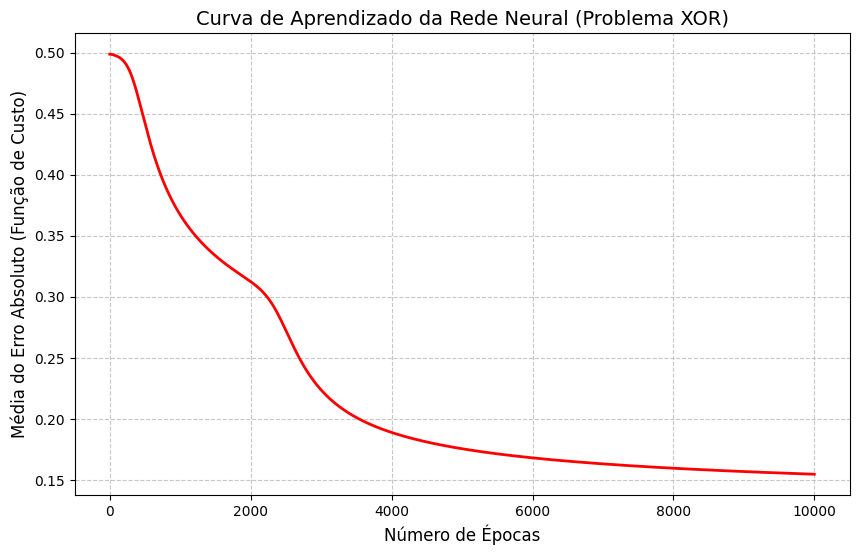

In [32]:
import matplotlib.pyplot as plt

print("=== Gerando a Curva de Aprendizado ===")

# Configurando o tamanho da figura (largura, altura)
plt.figure(figsize=(10, 6))

# Plotando a nossa lista que guardou o erro de cada época
# Usamos a cor vermelha e uma linha um pouco mais grossa para destacar
plt.plot(historico_custo, color='red', linewidth=2)

# Adicionando os títulos e rótulos
plt.title('Curva de Aprendizado da Rede Neural (Problema XOR)', fontsize=14)
plt.xlabel('Número de Épocas', fontsize=12)
plt.ylabel('Média do Erro Absoluto (Função de Custo)', fontsize=12)

# Adicionando uma grade sutil para facilitar a leitura dos valores
plt.grid(True, linestyle='--', alpha=0.7)

# Exibindo o gráfico final na tela
plt.show()